In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import utils
from tensorflow.python.client import device_lib
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Cropping2D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Nadam
from matplotlib import pyplot as plt
%matplotlib inline
device_lib.list_local_devices()

WIDTH, HEIGHT = 124, 124
SOURCE_FILE = os.path.join('..', 'data', 'scull_set.txt.csv')

Using TensorFlow backend.


### Preprocessing

In [2]:
def preprocess_dataset(dataset):
    # Pop labels and transform them to vectors
    y = dataset.pop('label')
    y = y.values.reshape((-1, 1))
    # Reshape the features for CNN
    X = dataset.as_matrix().reshape(dataset.shape[0], 1, WIDTH, HEIGHT).astype(np.float32)
    # Norm data
    X /= 255
    # Convert labels to categorical values
    y = keras.utils.to_categorical(y, 2)
    return X, y

def get_shuffled_splitted_data(path=SOURCE_FILE):
    df = pd.read_csv(path)
    # Shuffle and split data into: 70% train, 20% test, 10% validation
    train, test, val = np.split(df.sample(frac=1), [int(.7*len(df)), int(.9*len(df))])    
    # Extract labels, normalize, preprocess for keras
    X_train, y_train = preprocess_dataset(train)
    X_test, y_test = preprocess_dataset(test)
    X_val, y_val = preprocess_dataset(val)
    return X_train, y_train, X_test, y_test, X_val, y_val

# Collect new dataset containing sagittal images including scull and tumor
X_train, y_train, X_test, y_test, X_val, y_val = get_shuffled_splitted_data()

### Training the model (CNN)

In [55]:
def setup_model():
    model = Sequential()
    model.add(MaxPooling2D(pool_size=(7, 7), input_shape=(1, WIDTH, HEIGHT)))
    model.add(Conv2D(16, kernel_size=(1, 1)))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(2))
    model.add(Dropout(0.1))
    
    model.add(Dense(16))
    model.add(Dropout(0.1))
    
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy,
                  optimizer=Nadam(),
                  metrics=['accuracy'])
    return model

with tf.device('/gpu:0'):
    K.set_image_dim_ordering('th')
    batch_size = 36
    num_classes = 2
    epochs = 3
    # For storing the validation loss values
    history = keras.callbacks.History()
    # Train model
    model = setup_model()
    model_results = model.fit(X_train, y_train,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data=(X_test, y_test),
                              callbacks=[history])
    # Evaluate model on validation set
    print('\nValidate model on {} unknown validation samples:'.format(X_val.shape[0]))
    val_score = model.evaluate(X_val, y_val, verbose=0)
    print('Val loss:', val_score[0])
    print('Val accuracy:', val_score[1])

Train on 3098 samples, validate on 885 samples
Epoch 1/3
3098/3098 [==============================] - 2s - loss: 0.1830 - acc: 0.9180 - val_loss: 0.0119 - val_acc: 1.0000
Epoch 2/3
3098/3098 [==============================] - 1s - loss: 0.0170 - acc: 0.9939 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 3/3
3098/3098 [==============================] - 1s - loss: 0.0113 - acc: 0.9948 - val_loss: 0.0025 - val_acc: 1.0000

Validate model on 443 unknown validation samples:
Val loss: 0.00180504257758
Val accuracy: 1.0


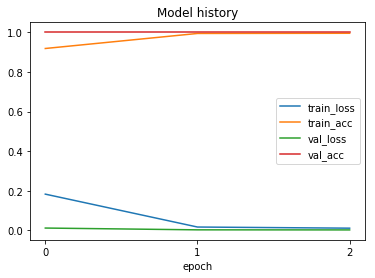

In [56]:
# Plot validation loss
utils.plot_history(model_results)

### Plotting results

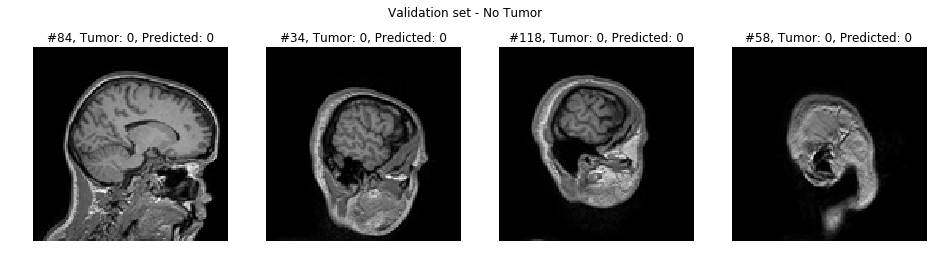

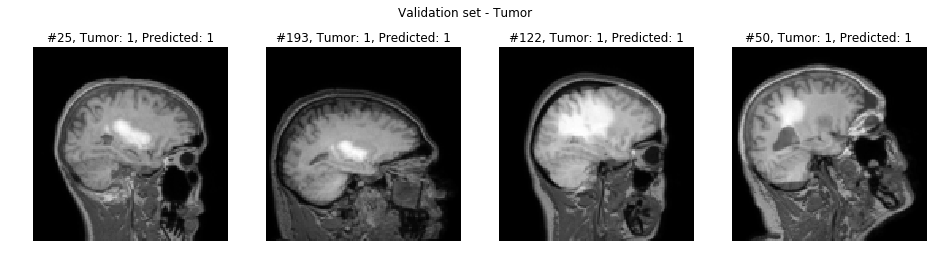

In [57]:
# Always same results
np.random.seed(1)
y_val_pred = model.predict(X_val, batch_size=32, verbose=0)
y_val_pred = np.round(y_val_pred).astype(int)
no_tumors = y_val.argmax(axis=1) == 0
utils.plot_predicted_samples(4, X_val[no_tumors], y_val[no_tumors], y_val_pred[no_tumors], 'Validation set - No Tumor')
utils.plot_predicted_samples(4, X_val[no_tumors == False], y_val[no_tumors == False], y_val_pred[no_tumors == False], 'Validation set - Tumor')

### Analysis

Our network converges unexpectedly quickly. This might be due to the following problems:
- The tumor images are resized and are somewhat blurred
- For some tumor images you can easily see that it has been created by two seperate pictures
- The healthy images contain sometimes a very different shape (e.g. above #108)

### Model structure 

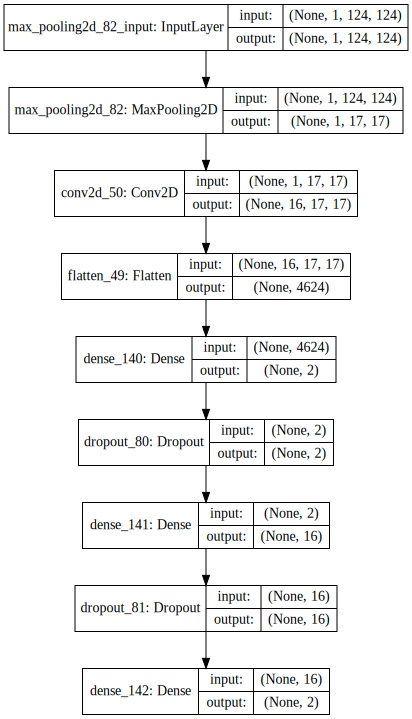

In [58]:
# Reload utils model if you changed a function
# import imp
# imp.reload(utils)
utils.plot_model(model, 'skull_classification_model.png')

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d_82 (MaxPooling (None, 1, 17, 17)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 16, 17, 17)        32        
_________________________________________________________________
flatten_49 (Flatten)         (None, 4624)              0         
_________________________________________________________________
dense_140 (Dense)            (None, 2)                 9250      
_________________________________________________________________
dropout_80 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_141 (Dense)            (None, 16)                48        
_________________________________________________________________
dropout_81 (Dropout)         (None, 16)                0         
__________